In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = False  ### if the Net isn't originally mapped -> False
rgb = False

transform = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

spada e scuda


In [33]:
class GalaxyJungle(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mappy=False, is_rgb=False):
        self.rgb = is_rgb
        self.mappy = mappy
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    
    def __len__(self): return (self.img_labels).shape[0]

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        if self.transform: image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1:]        
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.mappy: label = zk.mappy(label)

        gal_id = self.img_labels.iloc[idx, 0]

        return image, label, gal_id

In [34]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()


    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


# Validation Labels

In [35]:
training_sample = zk.mappy_df(pd.read_csv('../data/validation/validation_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A             17
E0          2309
E3          2862
E6           511
S0a_eon      724
SAa            8
SAb          436
SAc          955
SAd           39
SB0a_eon      10
SBa            5
SBb          218
SBc          213
SBd           17
Scd_eon      326
SoA         2075
SoB          359
dtype: int64

# Training Labels

In [36]:
training_sample = zk.mappy_df(pd.read_csv('../data/training/training_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A              82
E0           9122
E3          11209
E6           2153
S0a_eon      3080
SAa            49
SAb          1815
SAc          3716
SAd           164
SB0a_eon       46
SBa             6
SBb           867
SBc           886
SBd            48
Scd_eon      1384
SoA          8376
SoB          1333
dtype: int64

# Model Predicition on Test Labels

In [37]:
DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transform, mappy=True, is_rgb=rgb)
test_loader = DataLoader(DS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

model = GalaxyNet(nn.LeakyReLU, initialization=False, mappy=False, is_rgb=rgb).to(device)
loader = torch.load('/home/teobaldo/Uni/LCP-B/proj/Padel_final/model_optim_110.pt', weights_only=True)
model.load_state_dict(loader['model_state_dict'])


tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
loss = 0
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, GalaxyID = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            loss += np.sqrt(nn.MSELoss()(outputs, labels).item())
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID,outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)
print('Test loss', loss/len(test_loader))

Convs output size: 2


13it [00:08,  1.60it/s]

Test loss 0.060448818232772705


In [38]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

true_results = zk.mappy_df(pd.read_csv('../data/test/test_solutions_rev1.csv'))
true_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
true_results['true_label'] = true_results.iloc[:,1:].idxmax(axis=1)
true_results['true_value'] = true_results.iloc[:,1:-1].max(axis=1)

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


In [39]:
true_new = true_results
# true_new = true_results[true_results['true_value'] > 0.6]
confronto = pd.merge(train_results[['GalaxyID', 'train_label']], true_new[['GalaxyID', 'true_label']], on='GalaxyID')
total_count = confronto.groupby('true_label').size().reset_index(name='total_count')
mislabels = confronto[confronto['train_label'] != confronto['true_label']]

count = mislabels.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)
final_count = pd.merge(total_count, count, on='true_label', how='left').sort_values(by='num_misclassified', ascending=False)
final_count['score'] = np.round((1 - final_count['num_misclassified'] / final_count['total_count']), 2) * 100
final_count.sort_values(by='score', ascending=False, inplace=True)
display(final_count)

,true_label,total_count,num_misclassified,score
1,E0,1273,104,92.0
0,A,11,1,91.0
2,E3,1537,264,83.0
7,SAc,531,149,72.0
4,S0a_eon,408,116,72.0
3,E6,290,105,64.0
14,Scd_eon,169,71,58.0
6,SAb,278,143,49.0
12,SBc,116,65,44.0
11,SBb,143,80,44.0


In [40]:
group_pred = confronto.groupby(['true_label','train_label']).count()
pd.set_option('display.max_rows', None)
display(group_pred)

GalaxyID
true_label train_label          
A          A                  10
           E0                  1
E0         A                   2
           E0               1169
           E3                 56
           SAb                 2
           SAc                 2
           SBb                 1
           SoA                39
           SoB                 2
E3         A                   1
           E0                100
           E3               1273
           E6                 18
           S0a_eon             7
           SAb                 8
           SAc                 8
           SoA               118
           SoB                 4
E6         E3                 26
           E6                185
           S0a_eon            48
           SAc                 2
           Scd_eon            18
           SoA                11
S0a_eon    A                   2
           E3                 11
           E6                 46
           S0a_eon           292
           SAb                 6
           SAc                 7
           Scd_eon            22
           SoA                18
           SoB                 4
SAa        E3                  2
           S0a_eon             1
           SoA                 3
SAb        E0                  8
           E3                 14
           S0a_eon             6
           SAb               135
           SAc                47
           SBb                11
           SBc                 4
           Scd_eon             1
           SoA                51
           SoB                 1
SAc        E0                 13
           E3                 25
           E6                  8
           S0a_eon             5
           SAb                27
           SAc               382
           SAd                 1
           SBb                 1
           SBc                11
           Scd_eon             2
           SoA                56
SAd        E3                  2
           E6                  3
           SAc                 9
           SoA                 2
SB0a_eon   E0                  1
           E3                  1
           S0a_eon             4
SBa        SoA                 1
SBb        E0                  1
           E3                  2
           E6                  1
           S0a_eon             1
           SAb                35
           SAc                 6
           SBb                63
           SBc                13
           SoA                 9
           SoB                12
SBc        E0                  1
           E3                  6
           SAb                 9
           SAc                21
           SBb                18
           SBc                51
           SoA                 1
           SoB                 9
SBd        SAc                 1
           SBc                 2
           SoB                 1
Scd_eon    E0                  1
           E6                 27
           S0a_eon            36
           SAc                 3
           Scd_eon            98
           SoA                 4
SoA        E0                222
           E3                281
           E6                 47
           S0a_eon            23
           SAb                22
           SAc                78
           SAd                 2
           SBb                 2
           SBc                 1
           SBd                 1
           Scd_eon             8
           SoA               471
           SoB                14
SoB        E0                 24
           E3                 22
           E6                  6
           S0a_eon             6
           SAb                 4
           SAc                 5
           SBb                 9
           SBc                 6
           SoA                34
           SoB                81

# Model Predicition on Unlabeled Test

In [ ]:
class UnlabeledTest(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        with os.scandir(img_dir) as dir:
            for file in dir:
                self.data.append(file.name)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx])
        image = Image.open(img_path).convert('L')
        if self.transform: image = self.transform(image)
        return image, int(self.data[idx][:-4])
    
    def __len__(self):
        return len(self.data)

In [42]:
NDS = UnlabeledTest('../data/unl_test', transform)
test_loader = DataLoader(NDS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs, GalaxyID = vdata
            inputs = inputs.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID, outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)

157it [01:24,  1.85it/s]


In [43]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)
display(train_results.groupby('train_label').size())

train_label
A            149
E0         19670
E3         22600
E6          4576
S0a_eon     5507
SAa            2
SAb         2982
SAc         7704
SAd           50
SBb         1184
SBc         1086
SBd            8
Scd_eon     2177
SoA        10544
SoB         1736
dtype: int64

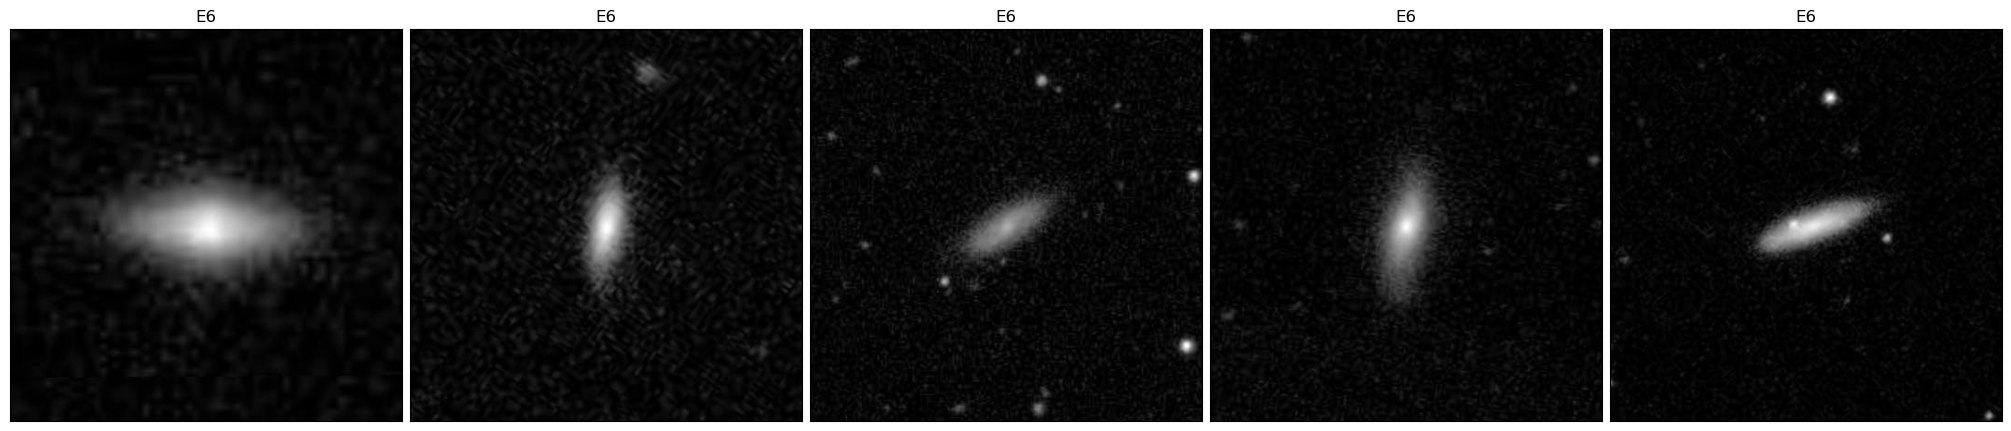

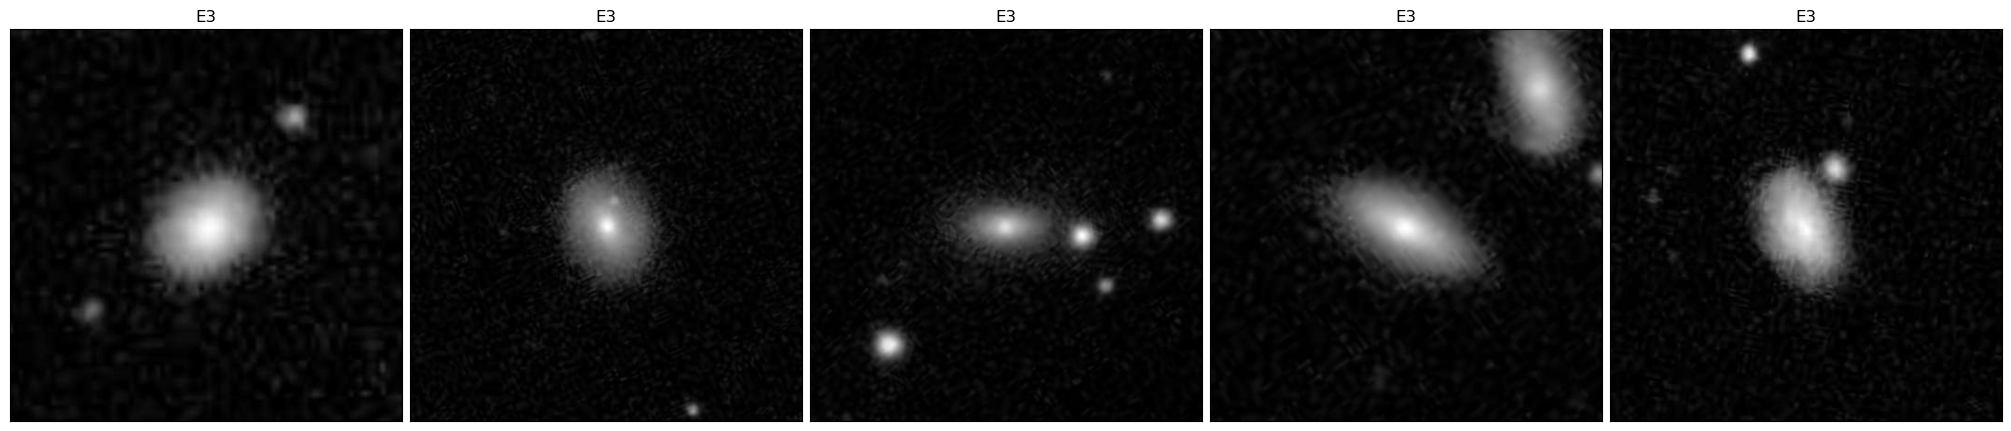

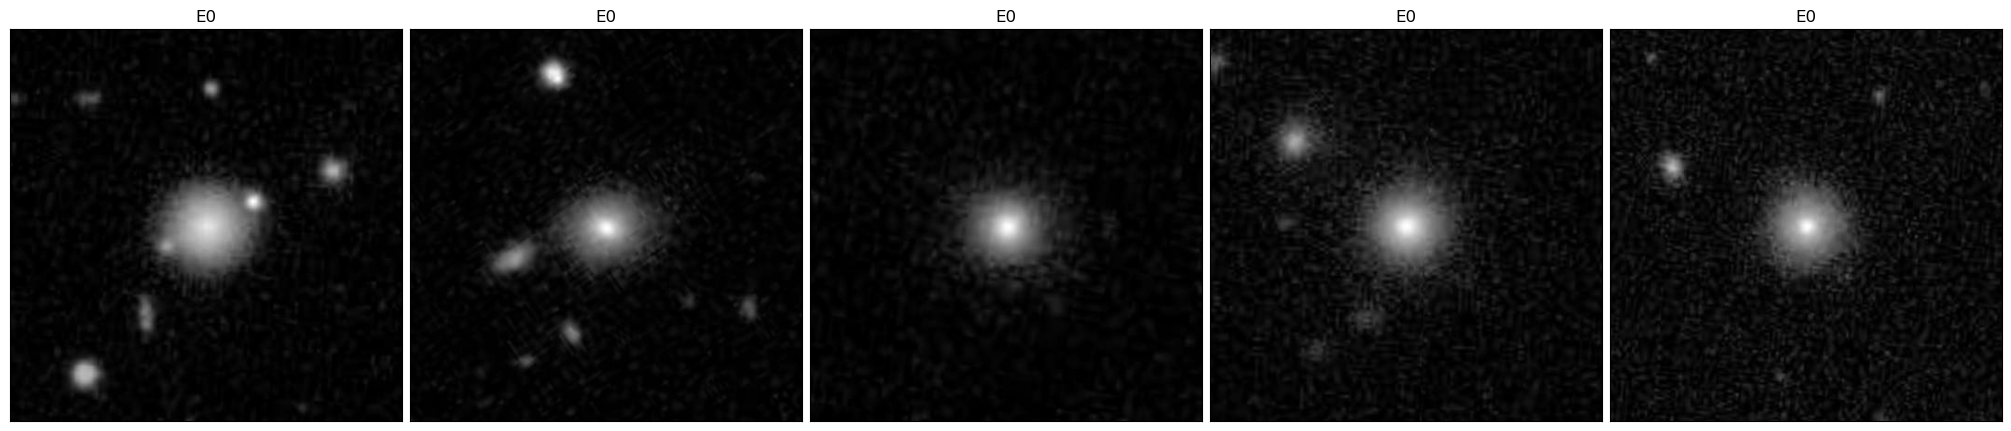

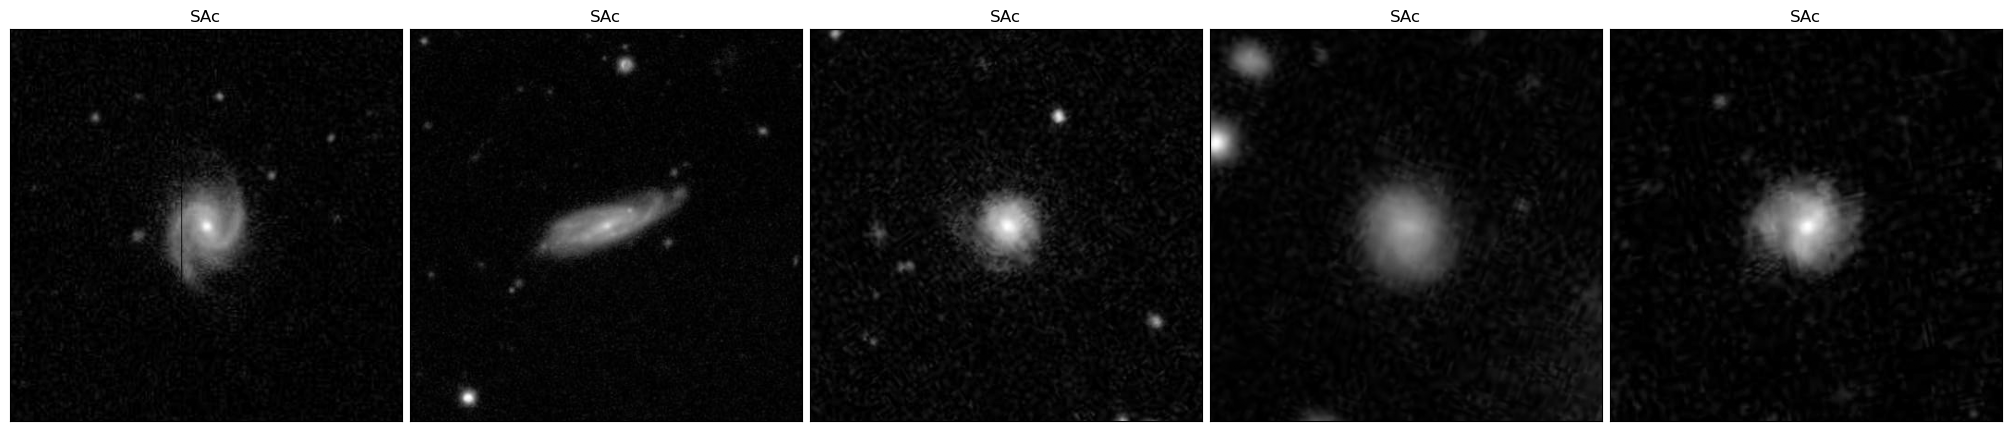

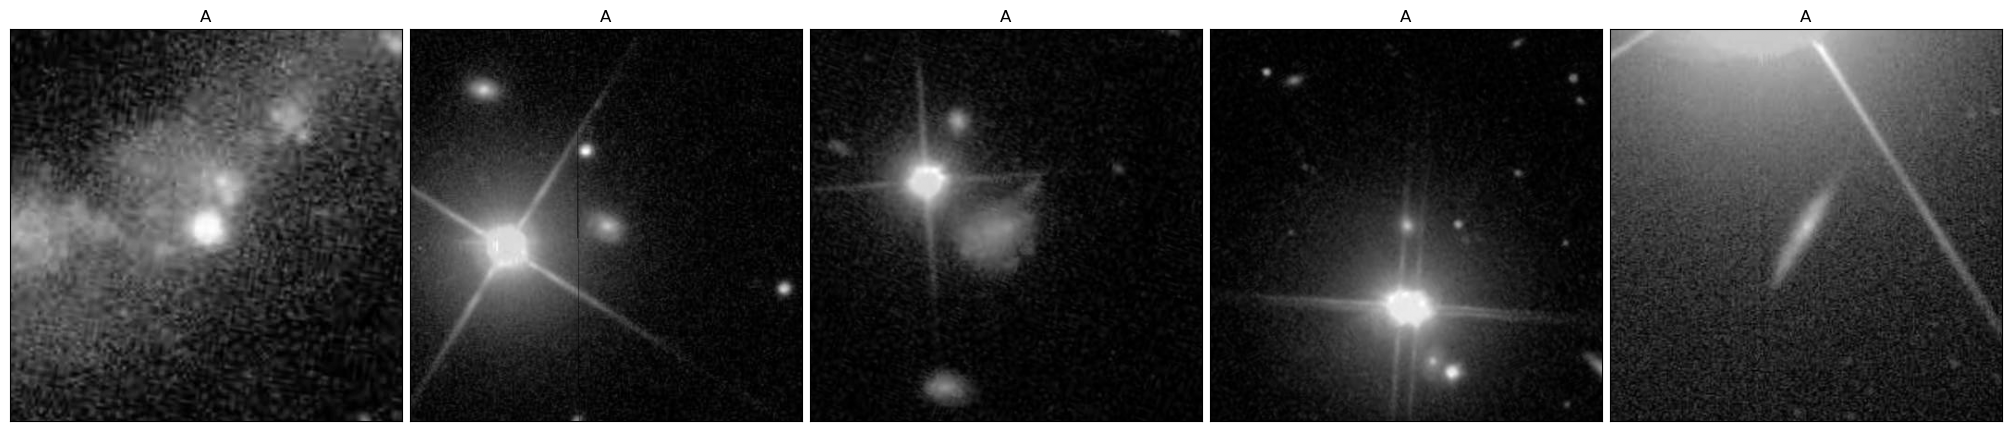

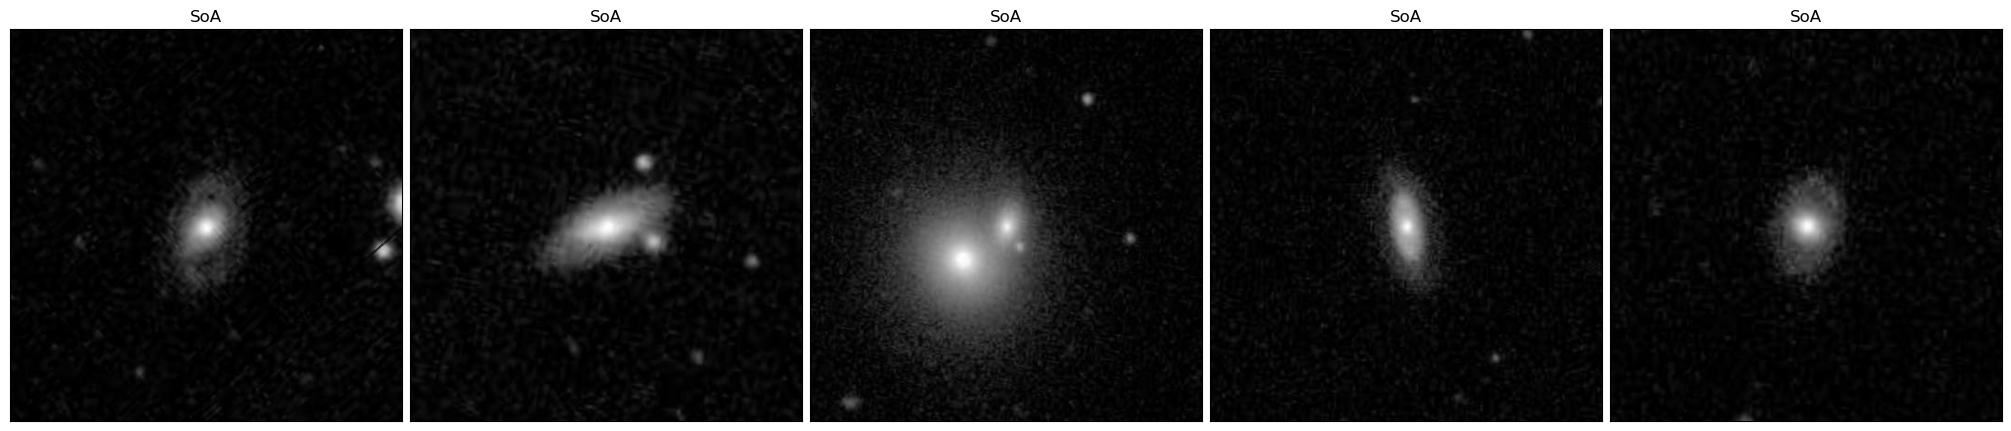

In [45]:
gal_type = ['E6', 'E3', 'E0', 'SAc', 'A', 'SoA']
gal_num = 5
ids = []
for id in gal_type: ids.append(train_results[train_results['train_label'] == id].sample(gal_num)['GalaxyID'].to_numpy())

for j, Type in enumerate(gal_type):
    fig, Ax = plt.subplots(1, gal_num, figsize=(20, 8), layout='constrained')
    for i, ax in enumerate(Ax):
        ax.set_aspect('equal', 'box')
        ax.imshow(Image.open('../data/unl_test/' +  str(ids[j][i]) + '.jpg').convert('L'), cmap='gray')
        ax.set_title(Type)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()